In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from _bus_cost_utils import GCS_PATH, new_outlier_flag_v2
from IPython.display import Markdown, display, HTML
from matplotlib.ticker import ScalarFormatter
from scipy.stats import zscore
from IPython.display import Markdown, display

In [2]:
merged_data = pd.read_parquet(f'{GCS_PATH}cleaned_no_outliers_cpb_analysis_data_merge.parquet')

In [3]:
# for subsetting ZEB and nonZEB
zeb_list =[
    "BEB",
    "FCEB",
    "electric (not specified)",
    "zero-emission bus (not specified)",
]

non_zeb_list =[
    "CNG",
    "ethanol",
    "low emission (hybrid)",
    "low emission (propane)",
    "mix (zero and low emission)",
]

In [4]:
# means and standard deviations
# for graphs
cpb_mean = merged_data["cost_per_bus"].mean()
cpb_std = merged_data["cost_per_bus"].std()

#testing weighted average calculation for sub-set non-zeb and zeb
zeb_cpb_wt_avg = (merged_data[merged_data["prop_type"].isin(zeb_list)]["total_cost"].sum() / merged_data[merged_data["prop_type"].isin(zeb_list)]["bus_count"].sum())
non_zeb_cpb_wt_avg = (merged_data[merged_data["prop_type"].isin(non_zeb_list)]["total_cost"].sum() / merged_data[merged_data["prop_type"].isin(non_zeb_list)]["bus_count"].sum())

In [5]:
def new_cpb_aggregate(df: pd.DataFrame, column="transit_agency") -> pd.DataFrame:
    """
    function to aggregate compiled data by different categories:
        "transit agency", 
        "propulsion type", 
        "bus_size_type",
        "new_project_type"
    aggregate on columns:
        "project_title"
        "ppno"
        "total_cost"
        "bus_count"
        
    Then, cost per bus is calculated AFTER the aggregation.
    """
    df_agg = (
        df.groupby(column)
        .agg(
            total_project_count=("project_title", "count"),
            total_project_count_ppno=("ppno", "count"),
            total_agg_cost=("total_cost", "sum"),
            total_bus_count=("bus_count", "sum"),
            #new_prop_type=("prop_type","max")
        )
        .reset_index()
    )
    df_agg["new_cost_per_bus"] = (df_agg["total_agg_cost"] / df_agg["total_bus_count"]).astype("int64")
    
    #calculate zscore
    df_agg["new_zscore_cost_per_bus"] = zscore(df_agg["new_cost_per_bus"])
    
    #flag outliers
    df_agg["new_is_cpb_outlier?"] = new_outlier_flag_v2(df_agg,'zscore_cost_per_bus')
    
    return df_agg

In [6]:
def bus_min_max_summary(data:pd.DataFrame, col1:str, col_list=["transit_agency",
                                                     "total_agg_cost",
                                                     "total_bus_count",
                                                     "new_cost_per_bus"]):
    """
    function to display min/max of specific column in aggregated bus df.
    
    """

    return display(Markdown(f"**Max {col1}**"),
    data[data[col1] == data[col1].max()][col_list].style.hide(axis="index"),
    Markdown(f"**Min {col1}**"),
    data[data[col1] == data[col1].min()][col_list].style.hide(axis="index"))
                  

In [7]:
def make_chart(y_col: str, title: str, data: pd.DataFrame, x_col: str):
    """
    function to create chart. sorts values by y_col ascending."""
    

    sorted_data = data.sort_values(by=y_col, ascending=False).head(10)
    ax = sorted_data.plot(
        x=x_col, y=y_col, kind="bar", color="skyblue"
    )
    
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    
    for bar in ax.patches:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}', 
            ha='center', va='bottom'
        )

    plt.ticklabel_format(style="plain", axis="y")
    plt.show()

In [8]:
def dist_curve(
    df: pd.DataFrame,
    mean: str,
    std: str,
    title: str,
    xlabel: str,
):
    """
    function to make distribution curve. uses the "cpb" column of the df.
    """
    sns.histplot(df["cost_per_bus"], kde=True, color="skyblue", bins=20)
    # mean line
    plt.axvline(
        mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
    )
    # mean+1std
    plt.axvline(
        mean + std,
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Standard Deviation: ${std:,.2f}",
    )
    plt.axvline(mean - std, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 2), color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 3), color="green", linestyle="dashed", linewidth=2)

    plt.title(title + " with Mean and Standard Deviation")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

    # Turn off scientific notation on x-axis?
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.legend()
    plt.show()

    return

In [9]:
# aggregating by big categories
agg_agency = new_cpb_aggregate(merged_data)
agg_prop = new_cpb_aggregate(merged_data, column="prop_type")
agg_bus_size = new_cpb_aggregate(merged_data, column="bus_size_type")
agg_source = new_cpb_aggregate(merged_data, column="source")

In [10]:
# subsetting ZEB and nonZEB data
zeb_projects = merged_data[merged_data["prop_type"].isin(zeb_list)]

non_zeb_projects = merged_data[merged_data["prop_type"].isin(non_zeb_list)]

In [11]:
#pivot table to get totals for each prop type

pivot_prop_type = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()
pivot_prop_type["cost_per_bus"] = (pivot_prop_type["total_cost"] / pivot_prop_type["bus_count"]).astype("int64")

In [12]:
#pivot for ZEB data

pivot_zeb_prop = pd.pivot_table(
    #filted incoming DF for zeb prop types
    zeb_projects,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()              

pivot_zeb_prop["cost_per_bus"] = (pivot_zeb_prop["total_cost"] / pivot_zeb_prop["bus_count"]).astype("int64")

In [13]:
#pivot for non-ZEB data

pivot_non_zeb_prop = pd.pivot_table(
    #filted incoming DF for non-zeb prop types
    non_zeb_projects,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()

pivot_non_zeb_prop["cost_per_bus"] = (pivot_non_zeb_prop["total_cost"] / pivot_non_zeb_prop["bus_count"]).astype("int64")

In [14]:
# pivot for bus sizes

pivot_size = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    # multi-index pivot
    index = ["prop_type","bus_size_type"],
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
)

pivot_size["cost_per_bus"] = (pivot_size["total_cost"] / pivot_size["bus_count"]).astype("int64")

In [15]:
#pivot for data soruces
pivot_source = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "source",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()

pivot_source["cost_per_bus"] = (pivot_source["total_cost"] / pivot_source["bus_count"]).astype("int64")

In [16]:
# new summary

intro = f"""

# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type with a focus on Zero Emission Buses (ZEB).

Data was compiled from three data sources:
1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. TIRCP project data (state-funded, California only data)
3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc.. 

The initial dataset included nearly 300 projects. It was reduced to {len(merged_data)} projects after applying criteria to exclude non-bus related work. 
Projects involving the construction of new facilities, training programs, or the procurement of non-bus items such as trains and ferries were excluded. 
The final dataset comprised only projects focused on bus procurement. 


These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.

**ZEB projects are categorized into the following propulsion types:**
- zero-emission (not specified) 
- electric (not specified)
- battery electric (BEB)
- fuel cell electric (FCEB)

**Non-ZEB projects include the following propulsion types:**
- compressed natural gas (CNG) 
- ethanol 
- low-emission (hybrid, propane) 
- diesel 
- gas

Below is a breakdown of each data source showing the total buses and cost for each source:
"""


In [17]:
display(
    Markdown(intro),
    pivot_source.style.hide(axis="index"),
    Markdown(f"<br>The following charts and tables display the kinds of variations to bus cost transit agencies have faced.")
)



# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type with a focus on Zero Emission Buses (ZEB).

Data was compiled from three data sources:
1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. TIRCP project data (state-funded, California only data)
3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc.. 

The initial dataset included nearly 300 projects. It was reduced to 88 projects after applying criteria to exclude non-bus related work. 
Projects involving the construction of new facilities, training programs, or the procurement of non-bus items such as trains and ferries were excluded. 
The final dataset comprised only projects focused on bus procurement. 


These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.

**ZEB projects are categorized into the following propulsion types:**
- zero-emission (not specified) 
- electric (not specified)
- battery electric (BEB)
- fuel cell electric (FCEB)

**Non-ZEB projects include the following propulsion types:**
- compressed natural gas (CNG) 
- ethanol 
- low-emission (hybrid, propane) 
- diesel 
- gas

Below is a breakdown of each data source showing the total buses and cost for each source:


source,bus_count,total_cost,cost_per_bus
dgs,236.000000,250112853,1059800
fta,883.000000,391257025,443099
tircp,233.000000,187250513,803650
Grand Total,1352.000000,828620391,612884


<br>The following charts and tables display the kinds of variations to bus cost transit agencies have faced.

In [18]:
display(
    Markdown("# Charts and Tables"),
)

# Charts and Tables

<br>

In [19]:
#summary stuff
display(
    Markdown("**Summary of cost by ZEB propulsion types**"),
    pivot_zeb_prop.style.hide(axis="index"),
    Markdown(f"<br><br>"),
    Markdown("**Summary of cost by non-ZEB propulsion types** *"),
    pivot_non_zeb_prop.style.hide(axis="index"),
    
    Markdown("*The remaining buses did not specify a propulsion type")
)

**Summary of cost by ZEB propulsion types**

prop_type,bus_count,total_cost,cost_per_bus
BEB,163.000000,167232489,1025966
FCEB,102.000000,120951335,1185797
electric (not specified),44.000000,56678000,1288136
zero-emission bus (not specified),143.000000,128156513,896199
Grand Total,452.000000,473018337,1046500


<br><br>

**Summary of cost by non-ZEB propulsion types** *

prop_type,bus_count,total_cost,cost_per_bus
CNG,252.000000,176039140,698568
ethanol,9.000000,1006750,111861
low emission (hybrid),145.000000,91824361,633271
low emission (propane),44.000000,8403969,190999
mix (zero and low emission),125.000000,36775430,294203
Grand Total,575.000000,314049650,546173


*The remaining buses did not specify a propulsion type

In [20]:
# overall summary
# commenting out for now.
#display(
#    Markdown("## Which Agencies has the highest and lowest overall cost per bus?"))
#bus_min_max_summary(data=agg_agency,col1="new_cost_per_bus")

In [21]:
# overall summary
# commenting out for now.
#display(
#    Markdown("## Which Agencies has the highest and lowest overall procurement cost?"))
#bus_min_max_summary(data=agg_agency,col1="total_agg_cost")

In [22]:
# overall summary
# commenting out for now.
#display(
#    Markdown("## Which Agencies procured the has the most and least overal number of buses?"))
#bus_min_max_summary(data=agg_agency,col1="total_bus_count")

<br>
<br>
<br>
<br>
<br>

In [23]:
## min max values of just ZEB projects
new_cols =[
    "transit_agency",
    "prop_type",
    "total_cost",
    "bus_count",
    "cost_per_bus"]
#
display(
    Markdown("## Which agencies had the highest and lowest ZEB cost per bus?"))
bus_min_max_summary(data=zeb_projects, col1="cost_per_bus", col_list=new_cols)


## Which agencies had the highest and lowest ZEB cost per bus?

**Max cost_per_bus**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
University of California - San Diego,BEB,4134000,2.000000,2067000


**Min cost_per_bus**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
City of Wasco,zero-emission bus (not specified),1543000,3.000000,514333


<br>

In [24]:
#
display(Markdown(
    "## Which agencies procured the most and least amount of ZEBs?"
))
bus_min_max_summary(data=zeb_projects, col1="bus_count", col_list=new_cols)


## Which agencies procured the most and least amount of ZEBs?

**Max bus_count**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
City of Los Angeles (LA DOT),zero-emission bus (not specified),102790000,112.000000,917767


**Min bus_count**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
"SLO TRANSIT (SAN LUIS OBISPO, CA)",BEB,847214,1.000000,847214
City of San Luis Obispo,BEB,859270,1.000000,859270


<br>

In [25]:
#
display(Markdown(
    "## Which agencies had the most and least total ZEB cost?"
))
bus_min_max_summary(data=zeb_projects, col1="total_cost", col_list=new_cols)

## Which agencies had the most and least total ZEB cost?

**Max total_cost**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
City of Los Angeles (LA DOT),zero-emission bus (not specified),102790000,112.000000,917767


**Min total_cost**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
"SLO TRANSIT (SAN LUIS OBISPO, CA)",BEB,847214,1.000000,847214


In [26]:
#display(Markdown(
#    "## Which agencies procured the most and least amount of ZEBs?"
#))
#bus_min_max_summary(data=zeb_projects, col1="bus_count", col_list=new_cols)


In [27]:
#display(Markdown(
#    "## Which agencies had the most and least total ZEB cost?"
#))
#bus_min_max_summary(data=zeb_projects, col1="total_cost", col_list=new_cols)

In [28]:
# all buses
# dont know if i need this anymore

#dist_curve(
#    df=merged_data,
#    mean=cpb_mean,
#    std=cpb_std,
#    title="all buses, cost per bus distribution",
#    xlabel="cost per bus, $ million(s)",
#)

In [29]:
# non-zeb cost per bus

#dist_curve(
#    df=non_zeb_projects,
#    mean=non_zeb_cpb_wt_avg,
#    std=non_zeb_projects["cost_per_bus"].std(),
#    title="non-ZEB cost per bus Distribution",
#    xlabel='"cost per bus, $ million(s)"',
#)

<br>
<br>

## What is the distribution of ZEB cost?

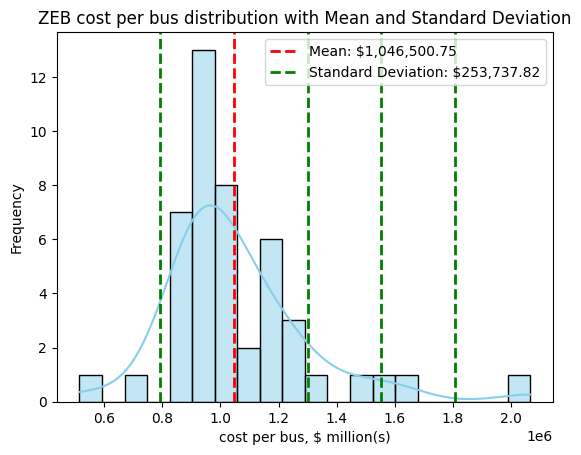

In [30]:
# ZEB cost per bus 
display(Markdown(
    "## What is the distribution of ZEB cost?"
))
dist_curve(
    df=zeb_projects,
    #using the accounting, weighted average approach to mean (total cost/total number of buses)
    mean=zeb_cpb_wt_avg,
    # need to investigate if std needs to be weighted as well?
    std=zeb_projects["cost_per_bus"].std(),
    title="ZEB cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)


In [31]:
dist_narrative = """This distribution show the ZEB cost floating around `~$1,000,000`, with only a few instances extending past +/- 1 standard deviation. 
As shown earlier, the lowest cost per ZEB bus was about `~$500,000`. However it should be noted that the propulsion type for this instance did not specify exactly which type of ZEB was procured (BEB, FCEB, or otherwise). 
The highest cost per ZEB was about `~$2,000,000` for BEB."""

display(
    Markdown(dist_narrative)
)

This distribution show the ZEB cost floating around `~$1,000,000`, with only a few instances extending past +/- 1 standard deviation. 
As shown earlier, the lowest cost per ZEB bus was about `~$500,000`. However it should be noted that the propulsion type for this instance did not specify exactly which type of ZEB was procured (BEB, FCEB, or otherwise). 
The highest cost per ZEB was about `~$2,000,000` for BEB.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


## What is the cost per bus compared against all propulsion types?

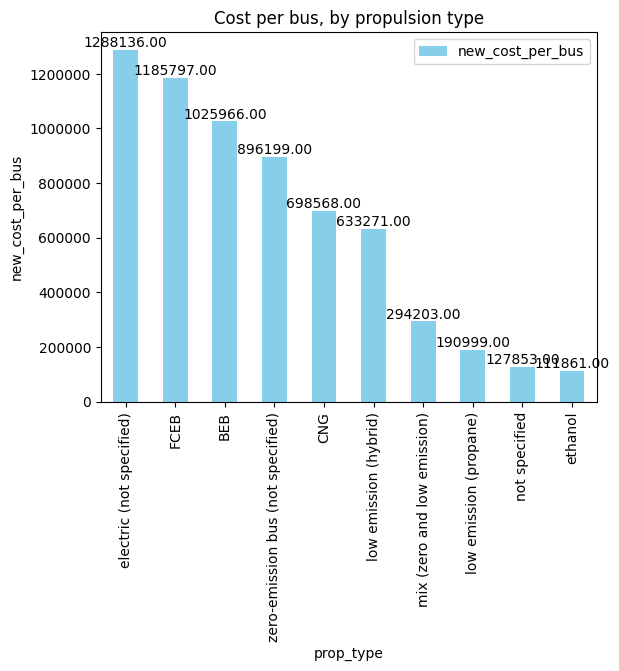

None

In [32]:
#
display(Markdown(
    "## What is the cost per bus compared against all propulsion types?"
))
display(
# cpb by prop type
make_chart("new_cost_per_bus", "Cost per bus, by propulsion type", x_col="prop_type", data=agg_prop),

# pivot table to
#agg_prop[["prop_type","new_cost_per_bus"]].sort_values(by="new_cost_per_bus", ascending=False).style.hide(axis="index")
)

<br>
<br>
<br>
<br>
<br>
<br>
<br>

## What is the total bus counts compared to each propulsion type?

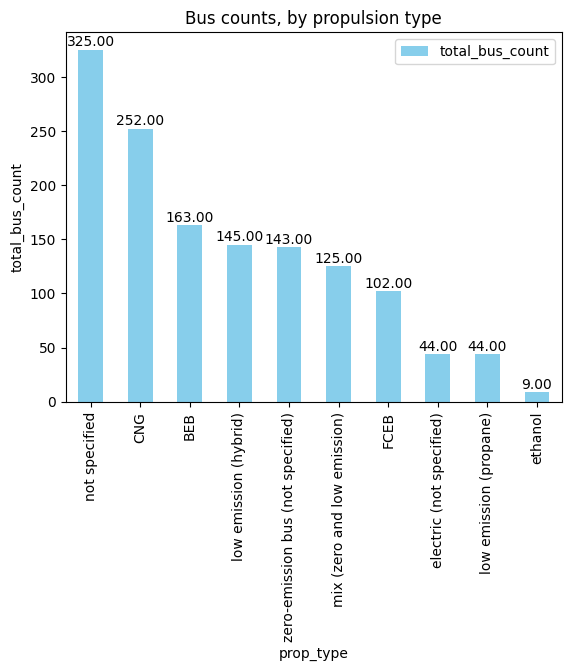

None

In [33]:
display(Markdown(
    "## What is the total bus counts compared to each propulsion type?"
))

display(
# bus count by prop type
make_chart("total_bus_count", "Bus counts, by propulsion type", x_col="prop_type", data=agg_prop),
# pivot table to
#agg_prop[["prop_type","total_bus_count"]].sort_values(by="total_bus_count", ascending=False).style.hide(axis="index")
)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## What is the total bus counts compared to each bus size category?

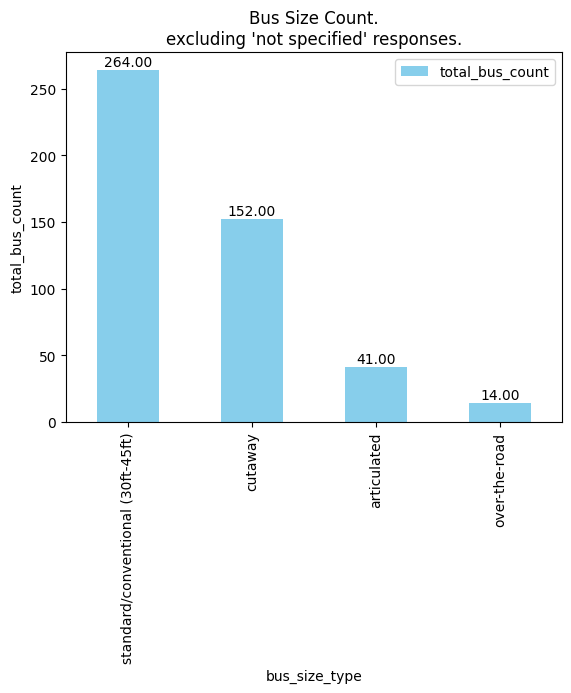

None

In [34]:
#bus size bar chart
display(Markdown(
    "## What is the total bus counts compared to each bus size category?"
))

display(
make_chart("total_bus_count", """Bus Size Count.
excluding 'not specified' responses.""", x_col="bus_size_type",data=agg_bus_size[agg_bus_size["bus_size_type"]!="not specified"]),
#agg_bus_size[["bus_size_type","total_bus_count"]].style.hide(axis="index")
)


<br>
<br>
<br>
<br>
<br>
<br>

In [35]:
display(
    Markdown("## What is the breakdown of ZEB Propulsion Type and Bus Size Category?"),
    pivot_size.loc[zeb_list]
)

## What is the breakdown of ZEB Propulsion Type and Bus Size Category?

bus_count  \
prop_type                         bus_size_type                                  
BEB                               articulated                             12.0   
                                  standard/conventional (30ft-45ft)      151.0   
FCEB                              not specified                           29.0   
                                  standard/conventional (30ft-45ft)       73.0   
electric (not specified)          articulated                             29.0   
                                  not specified                           15.0   
zero-emission bus (not specified) not specified                          143.0   

                                                                     total_cost  \
prop_type                         bus_size_type                                   
BEB                               articulated                          18759576   
                                  standard/conventional (30ft-45ft)   148472913   
FCEB                              not specified                        38070971   
                                  standard/conventional (30ft-45ft)    82880364   
electric (not specified)          articulated                          39478000   
                                  not specified                        17200000   
zero-emission bus (not specified) not specified                       128156513   

                                                                     cost_per_bus  
prop_type                         bus_size_type                                    
BEB                               articulated                             1563298  
                                  standard/conventional (30ft-45ft)        983264  
FCEB                              not specified                           1312792  
                                  standard/conventional (30ft-45ft)       1135347  
electric (not specified)          articulated                             1361310  
                                  not specified                           1146666  
zero-emission bus (not specified) not specified                            896199

<br>
<br>

In [36]:
conclusion = f"""
# **Conclusion**

Based on these findings, The average cost of a ZEB, throughout the US, is `~$1,000,000`, roughly twice the price of a conventional, non-ZEB.
The variance in cost depends mainly on the options the Transit Agencies chooses. Highly optioned/customized buses contribute to high cost.
Unfortunately, analyzing the cost of configurable options is outside the scope of data provided. 
 
"""
display(
    Markdown(conclusion)
)


# **Conclusion**

Based on these findings, The average cost of a ZEB, throughout the US, is `~$1,000,000`, roughly twice the price of a conventional, non-ZEB.
The variance in cost depends mainly on the options the Transit Agencies chooses. Highly optioned/customized buses contribute to high cost.
Unfortunately, analyzing the cost of configurable options is outside the scope of data provided. 
 
